## Predict Tidal EoS

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
plt.rcParams.update({'font.size': 20})

2022-07-23 00:03:47.718614: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### 1. Load data from file and prepare for training

Load the EoS and the $M-R$ curves from processed 3P/4L data files, then normalize the data.

In [2]:
# Load the un-normalized data
R = np.loadtxt('../data/mrc_td.txt')
P = np.loadtxt('../data/eos_td.txt')

# Normalize the data
r = (R - np.min(R)) / (np.max(R) - np.min(R))
p = (P - np.min(P)) / (np.max(P) - np.min(P))

Next, perform a train-test-validation split as 80-15-5.

In [3]:
# Perform train-test-validation split: 80-15-5
x_tr, x_tv, y_tr, y_tv = train_test_split(r, p, test_size=0.2, shuffle=True, random_state=41)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_tv, y_tv, test_size=0.25, shuffle=True, random_state=41)

### 2. Build DNN Model or load model from file

Construct a deep-learning neural network (DNN). The architecture and the hyperparameters of the DNN are chosen using `keras_tuner` to optimize for performance and accuracy (see `search/random_search_td.ipynb`). 

In [51]:
# Load model from file
#model = load_model("../output/model_td.h5")

# Build model from scratch
model = keras.Sequential([
    layers.Dense(200, input_shape=(100,), activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(100, activation='linear')])

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_17 (Dense)             (None, 500)               100500    
_________________________________________________________________
dense_18 (Dense)             (None, 300)               150300    
_________________________________________________________________
dense_19 (Dense)             (None, 100)               30100     
Total params: 301,100
Trainable params: 301,100
Non-trainable params: 0
_________________________________________________________________


### 3. Set up callbacks and training parameters

Set values of training parameters: batch size and number of epochs. Also, create optional callbacks such as early stopping and saving weights with checkpointings. 

In [52]:
batch_size = 32
num_epochs = 5000

# Set up a callback to stop early if given criteria is satisfied
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1.0e-10, patience=50)

# Setup checkpointing
ckpt_path = "../ckpts/eos_td.ckpt"
ckpt_dir = os.path.dirname(ckpt_path)

# Set up another callback that saves the model's weights
save_weights = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, save_weights_only=True, verbose=0)

### 4. Fit model and save training history

Train the DNN using training and testing data. Note that we still have unobserved validation data left to be used later for further testing and predicting EoS.

In [53]:
training = model.fit(x=x_tr, y=y_tr, batch_size=batch_size, validation_data=(x_ts, y_ts), \
                    epochs=num_epochs, callbacks=[stop_early, save_weights], verbose=2)

Epoch 1/5000
14/14 - 0s - loss: 0.0555 - val_loss: 0.0205
Epoch 2/5000
14/14 - 0s - loss: 0.0175 - val_loss: 0.0153
Epoch 3/5000
14/14 - 0s - loss: 0.0135 - val_loss: 0.0120
Epoch 4/5000
14/14 - 0s - loss: 0.0111 - val_loss: 0.0096
Epoch 5/5000
14/14 - 0s - loss: 0.0090 - val_loss: 0.0105
Epoch 6/5000
14/14 - 0s - loss: 0.0087 - val_loss: 0.0093
Epoch 7/5000
14/14 - 0s - loss: 0.0077 - val_loss: 0.0067
Epoch 8/5000
14/14 - 0s - loss: 0.0070 - val_loss: 0.0066
Epoch 9/5000
14/14 - 0s - loss: 0.0068 - val_loss: 0.0061
Epoch 10/5000
14/14 - 0s - loss: 0.0069 - val_loss: 0.0063
Epoch 11/5000
14/14 - 0s - loss: 0.0087 - val_loss: 0.0077
Epoch 12/5000
14/14 - 0s - loss: 0.0078 - val_loss: 0.0068
Epoch 13/5000
14/14 - 0s - loss: 0.0063 - val_loss: 0.0057
Epoch 14/5000
14/14 - 0s - loss: 0.0060 - val_loss: 0.0058
Epoch 15/5000
14/14 - 0s - loss: 0.0057 - val_loss: 0.0060
Epoch 16/5000
14/14 - 0s - loss: 0.0057 - val_loss: 0.0052
Epoch 17/5000
14/14 - 0s - loss: 0.0050 - val_loss: 0.0065
Epoch 

### 5. Check training results

Examine how well the network was trained by evaluating the model (i.e. computing the loss function) on the validation data and looking into the training history. Keep an eye on the order of magnitude of the loss function and any evidence of overfitting or underfitting. 

In [54]:
loss = model.evaluate(x_vl, y_vl, verbose=0)
print("Loss = {:.4e}".format(loss))

Loss = 4.5243e-04


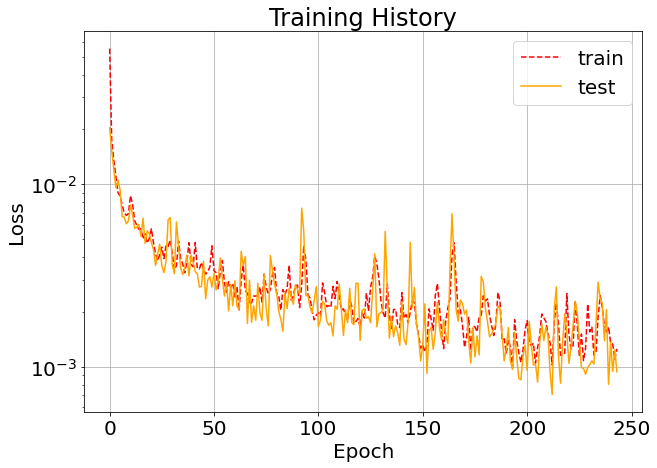

In [55]:
plt.figure(figsize=(10,7))
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

### 6. Predict EoS and compare with data

Evaluate model with validation data and de-normalize data and prediction.

In [56]:
x = x_vl
y = y_vl
pd = np.array(model(x))

# De-normalize data and prediction
pr = np.min(P) + (np.max(P) - np.min(P)) * pd
dt = np.min(P) + (np.max(P) - np.min(P)) * y

Choose a random $M-R$ curve and predict the corresponding EoS. Plot the predicted EoS and the data for comparison.

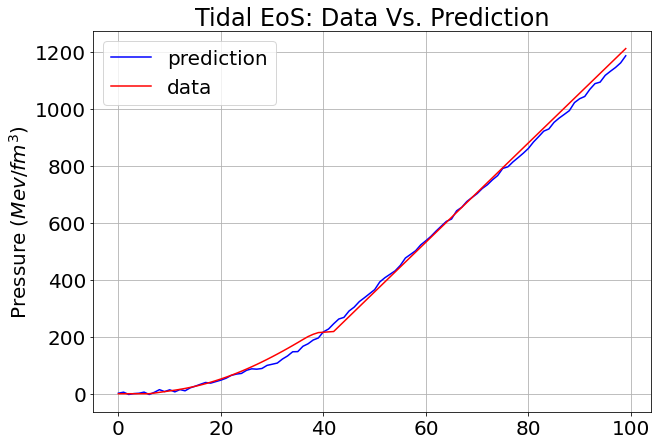

In [69]:
i = np.random.choice(x_vl.shape[0])

plt.figure(figsize=(10,7))
plt.plot(pr[i], color='blue', label='prediction')
plt.plot(dt[i], color='red', label='data')

plt.title("Tidal EoS: Data Vs. Prediction")
plt.ylabel("Pressure ($Mev/fm^3$)")
plt.legend()
plt.grid()
#plt.savefig(f"{FIGS}/real_vs_models.png")
plt.show()